## RETO OPTIMIZACIÓN ESTOCÁSTICA

* Ricardo Vargas Garduño A01026909
* Gian Marco Innocenti A00834310
* Alejandro Medrano Torres A00831829
* Juan David Rivera A01026193
* Esteban Pérez A00832329


---
Cargar los siguientes archivos:
* `informacion_compra.csv`
* `opti_input_VRP.csv`
* `direcciones.xlsx`

In [ ]:
!pip install ortools
!pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from random import random

from geopy.geocoders import Nominatim

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [ ]:
# Primero cargar el archivo "informacion_compra.xlsx" en la pestaña Archivos,
# en la barra lateral izquierda
df=pd.read_excel('/content/informacion_compra.xlsx')
df.rename(columns={' Unidades ': 'Unidades'}, inplace=True)
df.head()

,Producto,Unidades,Factura
0,48443,1,799186
1,42877,1,717106
2,48296,1,468125
3,34704,1,176490
4,47158,2,674550


### 1. Distribución de probabilidad del número de unidades que demanda un cliente.



In [ ]:
# Dataframe con cantidad de veces que se pidieron n productos por un mismo cliente
df_sum = df.groupby('Factura')['Unidades'].sum()
# Verificar que cada factura aparece 1 vez
#df_sum[df_sum.index.value_counts()>1]

cp = df_sum.value_counts().index
f = df_sum.value_counts().to_list()
fr = [x/sum(f) for x in f]

df_nProd = pd.DataFrame({
    'Cant_productos':   cp,
    'Frecuencia':       f,
    'Frec_relativa':    fr
    })
# Orden ascendente
df_nProd = df_nProd.sort_values(by='Frec_relativa', ascending=True)
df_nProd.index=range(len(df_nProd))


# Frecuencia acumulada
fa = [sum(df_nProd.Frec_relativa[:x+1]) for x in range(len(fr))]
df_nProd['Frec_acumulada'] = fa
# Límite inferior de intervalo de probabilidad
df_nProd['Lim_inf'] = [0] + [fa[x-1] for x in range(1, len(fa))]
# Límite superior de intervalo de probabilidad
df_nProd['Lim_sup'] = fa

df_nProd

,Cant_productos,Frecuencia,Frec_relativa,Frec_acumulada,Lim_inf,Lim_sup
0,23,1,0.000040,0.000040,0.000000,0.000040
1,24,1,0.000040,0.000081,0.000040,0.000081
2,14,1,0.000040,0.000121,0.000081,0.000121
3,27,1,0.000040,0.000161,0.000121,0.000161
4,22,1,0.000040,0.000202,0.000161,0.000202
5,21,1,0.000040,0.000242,0.000202,0.000242
6,19,2,0.000081,0.000323,0.000242,0.000323
7,13,2,0.000081,0.000403,0.000323,0.000403
8,18,2,0.000081,0.000484,0.000403,0.000484
9,16,4,0.000161,0.000645,0.000484,0.000645


In [ ]:
df_nProd.describe()

,Cant_productos,Frecuencia,Frec_relativa,Frec_acumulada,Lim_inf,Lim_sup
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,13.000000,1033.458333,0.041667,0.058713,0.017046,0.058713
std,7.655632,3946.736351,0.159123,0.206068,0.047743,0.206068
min,1.000000,1.000000,0.000040,0.000040,0.000000,0.000040
25%,6.750000,1.750000,0.000071,0.000302,0.000232,0.000302
50%,12.500000,7.000000,0.000282,0.001250,0.000968,0.001250
75%,19.250000,78.500000,0.003165,0.009182,0.006017,0.009182
max,27.000000,19235.000000,0.775511,1.000000,0.224489,1.000000


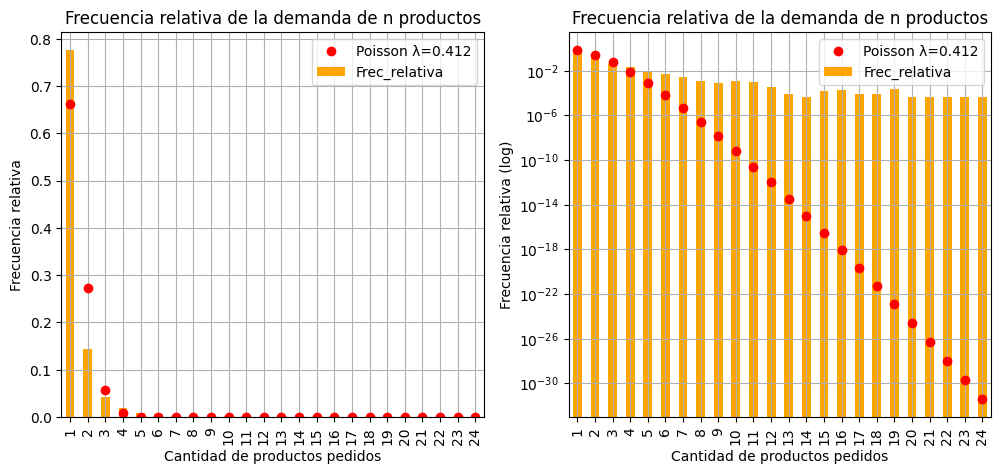

In [ ]:
plt.subplots(1, 2, figsize=(12,5))

plt.subplot(1, 2, 1)
df_nProd.sort_values(by='Cant_productos').Frec_relativa.plot.bar(color='orange')
plt.title('Frecuencia relativa de la demanda de n productos')
plt.xlabel('Cantidad de productos pedidos')
plt.ylabel('Frecuencia relativa')
plt.grid()
plt.xticks(range(0, 24), range(1, 25))


# Distribución de Poisson
l=round(df_sum.mean()-1, 3)  # Promedio de cantidad de productos pedidos por cliente
x = np.arange(0, 24)
y = poisson.pmf(x, mu=l)
plt.plot(x, y, 'ro', label=f'Poisson λ={l}')
plt.legend(loc='best')
#plt.yscale("log")




plt.subplot(1, 2, 2)
df_nProd.sort_values(by='Cant_productos').Frec_relativa.plot.bar(color='orange')
plt.title('Frecuencia relativa de la demanda de n productos')
plt.xlabel('Cantidad de productos pedidos')
plt.ylabel('Frecuencia relativa (log)')
plt.grid()
plt.xticks(range(0, 24), range(1, 25))


# Distribución de Poisson
x = np.arange(0, 24)
y = poisson.pmf(x, mu=l)
plt.plot(x, y, 'ro', label=f'Poisson λ={l}')
plt.legend(loc='best')
plt.yscale("log")
plt.show()

### 2. Distribución de probabilidad de demanda de los productos.




In [ ]:
productsId = df.Producto.unique()

frecuency = []
for p in productsId:
  frecuency.append(df[df.Producto==p].Unidades.sum())    # Filter the dataframe by product Id

In [ ]:
df_Prod = pd.DataFrame({
    'Id_producto': productsId,
    'Frecuencia': frecuency,
    'Frec_relativa': [x/sum(frecuency) for x in frecuency]
})

# Orden ascendente
df_Prod = df_Prod.sort_values(by='Frec_relativa', ascending=True)
df_Prod.index=range(len(df_Prod))

# Frecuencia acumulada
fa2 = [sum(df_Prod.Frec_relativa[:x+1]) for x in range(len(frecuency))]
df_Prod['Frec_acumulada'] = fa2
# Límite inferior de intervalo de probabilidad
df_Prod['Lim_inf'] = [0] + [fa2[x-1] for x in range(1, len(fa2))]
# Límite superior de intervalo de probabilidad
df_Prod['Lim_sup'] = fa2
df_Prod.tail(10)

,Id_producto,Frecuencia,Frec_relativa,Frec_acumulada,Lim_inf,Lim_sup
4751,34112,126,0.003598,0.948091,0.944494,0.948091
4752,47259,130,0.003712,0.951803,0.948091,0.951803
4753,24035,135,0.003855,0.955658,0.951803,0.955658
4754,47240,151,0.004311,0.959969,0.955658,0.959969
4755,34369,153,0.004369,0.964338,0.959969,0.964338
4756,34324,163,0.004654,0.968992,0.964338,0.968992
4757,17387,243,0.006938,0.975930,0.968992,0.975930
4758,34568,255,0.007281,0.983211,0.975930,0.983211
4759,24335,266,0.007595,0.990806,0.983211,0.990806
4760,34742,322,0.009194,1.000000,0.990806,1.000000


In [ ]:
df_Prod.describe()

,Id_producto,Frecuencia,Frec_relativa,Frec_acumulada,Lim_inf,Lim_sup
count,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000
mean,27429.013233,7.356228,0.000210,0.157165,0.156955,0.157165
std,15038.019317,16.125739,0.000460,0.184672,0.184282,0.184672
min,23.000000,1.000000,0.000029,0.000029,0.000000,0.000029
25%,17238.000000,1.000000,0.000029,0.034006,0.033978,0.034006
50%,28005.000000,2.000000,0.000057,0.084773,0.084716,0.084773
75%,40445.000000,6.000000,0.000171,0.209834,0.209662,0.209834
max,53475.000000,322.000000,0.009194,1.000000,0.990806,1.000000


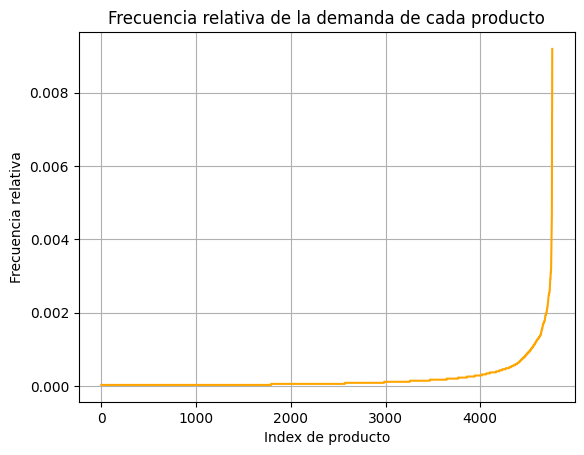

In [ ]:
df_Prod.Frec_relativa.plot(color='orange')
plt.title('Frecuencia relativa de la demanda de cada producto')
plt.xlabel('Index de producto')
plt.ylabel('Frecuencia relativa')
#plt.xticks([])
plt.grid()
plt.show()

### 3. Funciónes para generar `cantidad de productos` y `Id de producto` siguiendo sus respectivas distribuciones de probabilidad.


**Función para obtener una cantidad de productos aleatoria siguiendo su distribución aleatoria**

In [ ]:
def randnProd():
  # Random number between 0 and 15
  r = random()

  for i in range(len(df_nProd)):
    if((r >= df_nProd.iloc[i, 4]) and (r <= df_nProd.iloc[i, 5])):
      return df_nProd.iloc[i, 0]

randnProd()

6

**Función para obtener un Id de producto aleatorio siguiendo su distribución aleatoria**

In [ ]:
def randIdProd():
  # Random number between 0 and 15
  r = random()

  for i in range(len(df_Prod)):
    if((r >= df_Prod.iloc[i, 4]) and (r <= df_Prod.iloc[i, 5])):
      return df_Prod.iloc[i, 0]

randIdProd()

17473

### 4. Dataset con información de pedidos por cada cliente

Para cada cliente se ejecuta la función `randnProd` para determinar la cantidad de productos que pedirá; luego, la función `randIdProd` determinará el Id de esos productos.

In [ ]:
print(f'Cantidad de clientes: {len(df.Factura.unique())}')

Cantidad de clientes: 24803


In [ ]:
# Tardó 75 min para los 24803 clientes
""""
clients = df.Factura.unique()
products = []

for i in range(len(clients)):
  prod = []
  for j in range(randnProd()):
    prod.append(randIdProd())

  products.append(prod)

input_vrp = pd.DataFrame({
    'Cliente': clients,
    'Lista_id_productos': products
})

input_vrp.to_csv('pedidos.csv', index=False)
input_vrp
"""

'"\nclients = df.Factura.unique()\nproducts = []\n\nfor i in range(len(clients)):\n  prod = []\n  for j in range(randnProd()):\n    prod.append(randIdProd())\n\n  products.append(prod)\n\ninput_vrp = pd.DataFrame({\n    \'Cliente\': clients,\n    \'Lista_id_productos\': products\n})\n\ninput_vrp.to_csv(\'pedidos.csv\', index=False)\ninput_vrp\n'

**Importar archivo csv con información de pedidos de clientes y volumenes**

In [ ]:
input_vrp = pd.read_csv("opti_input_VRP.csv")
del input_vrp['Unnamed: 0']
input_vrp

,Client_ID,Numero_de_Productos_Ordenados,ID,Lista_de_Volumenes_de_Productos,Volumen_Total
0,799186,1,[17155],[0.001],0.001000
1,717106,1,[11175],[8.75e-06],0.000009
2,468125,1,[17240],[0.7637],0.763700
3,176490,1,[18143],[0.0009568],0.000957
4,674550,1,[23602],[0.006893],0.006893
...,...,...,...,...,...
24798,811225,1,[37266],[0.0035606],0.003561
24799,778814,1,[18143],[0.0009568],0.000957
24800,784747,1,[18599],[1.12],1.120000
24801,73823,1,[37467],[0.241743],0.241743


### 5. Dataset coordenadas de direcciones


In [ ]:
df_direcciones = pd.read_excel('direcciones.xlsx')
df_direcciones.head(3)

,Colonia,codigo postal,Calle,numero de casa
0,FIERRO MTY,64590,JESUS M GARZA,4026
1,VALLE DE SANTA LUCIA MTY,64140,LIC PEDRO ZORRI,404
2,JARDINES DEL PAS MTY,64900,AVE FUNDADORES,5300


In [ ]:
geolocator = Nominatim(user_agent="myGeocoder")
postal_codes = df_direcciones['Calle']
df_cp = pd.DataFrame()
# Agrega columnas para latitud y longitud
df_direcciones['Latitud'] = None
df_direcciones['Longitud'] = None

# Itera sobre las filas y realiza la geocodificación por código postal
for index, adress in enumerate(postal_codes):
  n = 0
  location = geolocator.geocode(adress, country_codes='MX')

  if location:
    df_direcciones.at[index, 'Latitud'] = location.latitude
    df_direcciones.at[index, 'Longitud'] = location.longitude
  else:
    n+=1
    #print(f"No se pudo obtener la geolocalización para el código postal en la fila {index}: {postal_code}")

print(f'NO se encontraron {n} direcciones')
df_coord = df_direcciones[df_direcciones.Latitud.isna()==False].copy()

NO se encontraron 1 direcciones


In [ ]:
df_coord.index = range(120)
df_coord.to_csv('coordenadas.csv', index=False)

In [ ]:
df_coord

,Colonia,codigo postal,Calle,numero de casa,Latitud,Longitud
0,FIERRO MTY,64590,JESUS M GARZA,4026,25.665653,-100.417499
1,JARDINES DEL PAS MTY,64900,AVE FUNDADORES,5300,20.622499,-87.075217
2,VILLA LOS PINOS MTY,64770,PINO SILVESTRE,2923,25.636429,-100.288347
3,URBI VILLA DEL REY,64102,LAGO TITICACA,209,21.483916,-104.860577
4,PORTAL DEL FRAILE,66064,FRAY JOSE,729,25.799552,-100.413892
...,...,...,...,...,...,...
115,VALLE D INF 1 SE MTY,64350,HERMES,421,24.822868,-107.423276
116,LOMA BONITA MTY,64250,ZOCALO,6141,19.432713,-99.133162
117,VILLA ALEGRE MTY,64130,VILLA ALEGRE,8616,25.65871,-100.173234
118,SAN JOSE MTY,64270,AV LINCOLN,2503,25.825554,-100.57397


---
## TEST CODE
